In [ ]:
! pip install weightwatcher  transformers 

## Makes plots for theory paper: Correlation Traps

### This is the simplest possible modern MLP, 3 layers trained on MNIST

**IMPORTANT**:
- First train the models. See WW_MLP3_Training_pytorch.ipynb or WW_MLP3_Training_keras.ipynb


In [2]:
# If you are running this NB in google colab then execute this cell

from google.colab import drive
drive.mount('/drive')
results_dir = '/drive/MyDrive/setol_paper'

!ls $results_dir

In [1]:
# If you are running this NB locally then set your results directory and execute this cell
import os
from pathlib import Path

from weightwatcher import WeightWatcher

from models import MLP3
from trainer import Trainer
from utils import last_epoch

os.chdir("../pytorch")
results_dir = "saved_models/SETOL"
!ls $results_dir

MNIST  OLD_FASHION  OLD_MNIST  TEST


### Correlation Trap plots

In the previous notebook, `WW_MLP3_Analysis_Model_Quality.ipynb`, we saw that as learning rate (LR) and batch size (BE) cross a threshold where model accuracy declines, there is also a threshold where the layer $\alpha$ metrics also decline. Here, we will see that in such cases -- and only in such cases -- there are **Correlation Traps** in the weight matrices. A Correlation Trap is an anomaly in the distribution of the weights such that when the elements are randomly permuted, the matrix no longer has a Marchenko-Pastur (MP) distribution.

Normally, when a layer is initialized, its weights have a $0$-mean, Gaussian or Uniform distribution, which implies that their ESDs *must* follow an MP distribution. As training progresses, the ESDs quickly depart from the MP distribution, but, the distribution of the weights remains consistent with the MP conditions. The conditions are, effectively, that distribution function is $0$-mean, and symmetrically, monotonically decreasing away from $0$.

Here we will show that as the LR or BS crosses a critical threshold, and as $\alpha$ also shows drastic effects, Correlation Traps also appear.

How are Correlation Traps detected? As long as the **distribution** of weights meets the MP criteria, then randomly permuting them causes them to be i.i.d. randomly drawn from that distribution, and the permuted matrix now meets the definition of a *Random Matrix*, or at least, the commonly studied class of i.i.d. random matrix to which the MP law applies. Contrapositively, if the weight distribution criteria are not met, then the MP law will *not* apply, and we can detect this. The procedure is to randomize the elements of $\mathbf{W}$, compute an ESD of $\mathbf{W}^T\mathbf{W}$, and check that the largest eigenvalue is within the support set of the MP distribution. 

In the plots below, the <font color='green'>green</font> plot is the original ESD, and the <font color='red'>red</font> plot is the randomized ESD. The <font color='orange'>orange</font> line shows where the largest randomized eigenvalue is. When there is a Correlation Trap, the <font color='orange'>orange</font> line will be separated out from the bulk of the MP distribution.

First, let's look at the five independent runs with batch size = $1$.

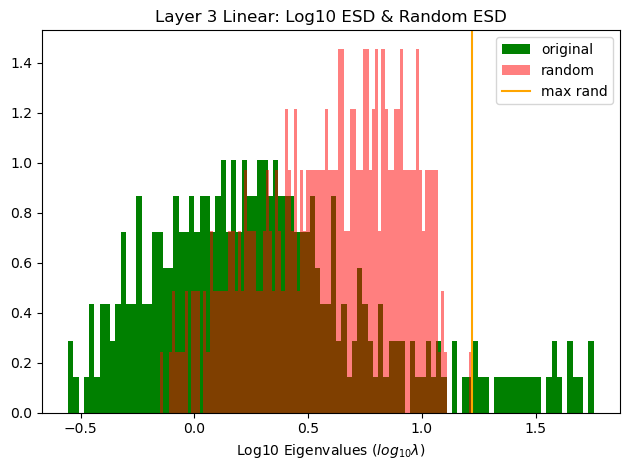

0    1.947846
Name: alpha, dtype: float64


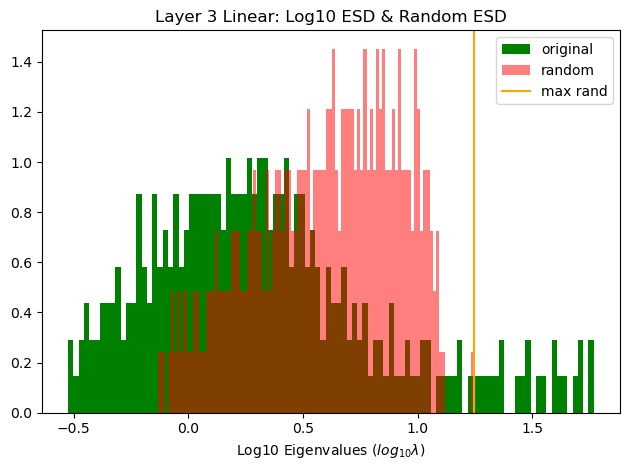

0    1.947937
Name: alpha, dtype: float64


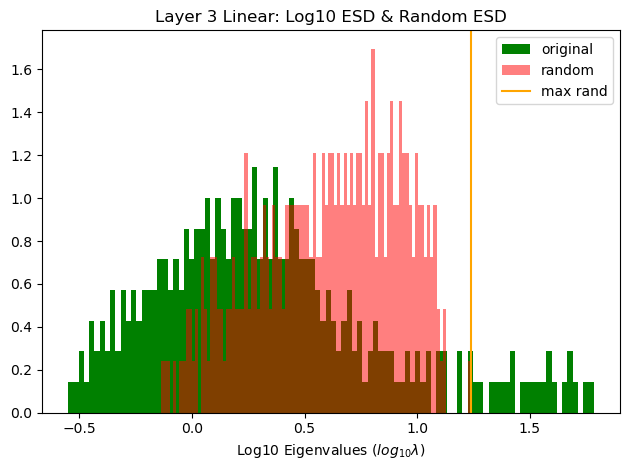

0    1.935643
Name: alpha, dtype: float64


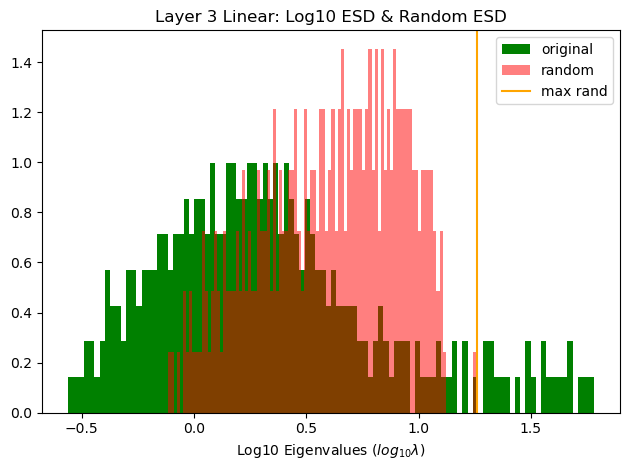

0    1.926516
Name: alpha, dtype: float64


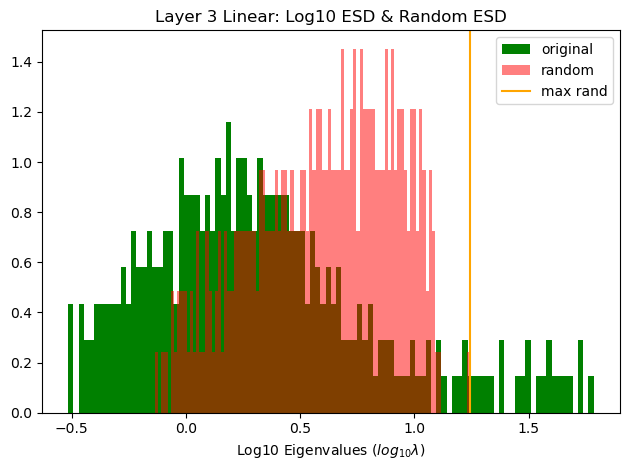

0    1.935682
Name: alpha, dtype: float64


<Figure size 640x480 with 0 Axes>

In [2]:
m = MLP3(widths=(300, 100), H=28, W=28, C=1)
t = Trainer(m)

DS = "MNIST"
layer = "all"
FC1 = 3
FC2 = 5
model_name = f"SETOL/{DS}/{layer}/BS_1"
for run in range(5):
  E = last_epoch(run, model_name)
  t.load(run, E, model_name)
  watcher = WeightWatcher(m)
  figdir = f"figs/correlation_traps/BS_1_FC1_{run}"
  Path(figdir).mkdir(parents=True, exist_ok=True)
  details = watcher.analyze(layers = [FC1], randomize=True, plot=["log_rand_esd"], savefig=figdir)
  print(details.alpha)

-----
Notice how the <font color='orange'>orange</font> line is separated. It's indicating that there permuted matrix has at least one large eigenvalue outside of its expected range.

### Now let's try it for batch size=2...

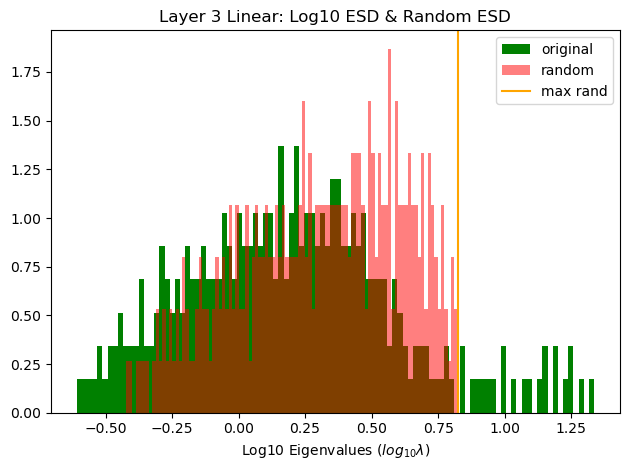

0    2.475519
Name: alpha, dtype: float64


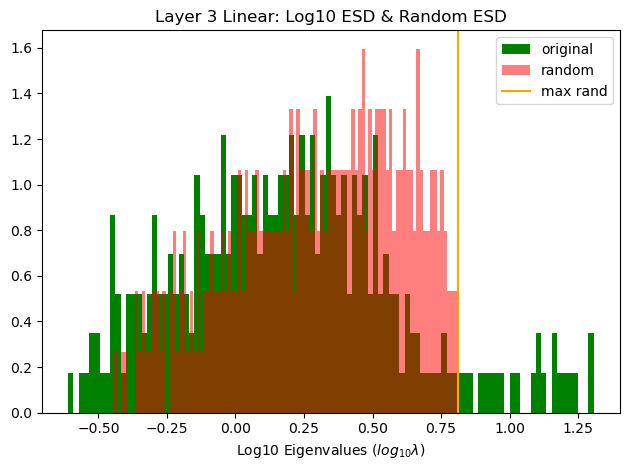

0    2.501417
Name: alpha, dtype: float64


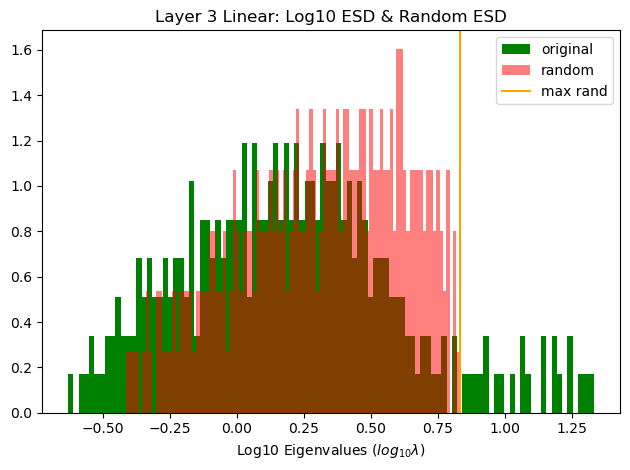

0    2.443049
Name: alpha, dtype: float64


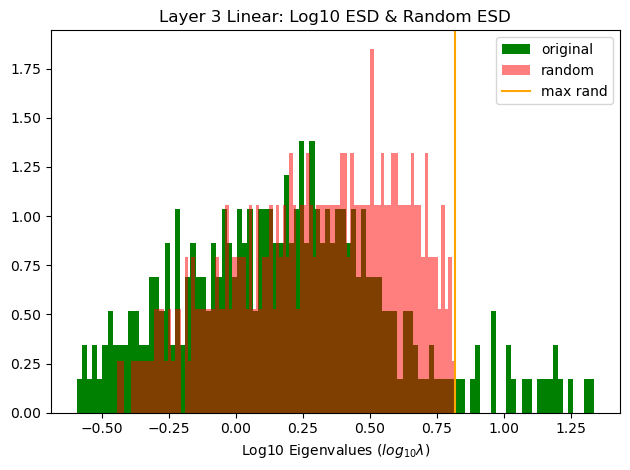

0    2.481154
Name: alpha, dtype: float64


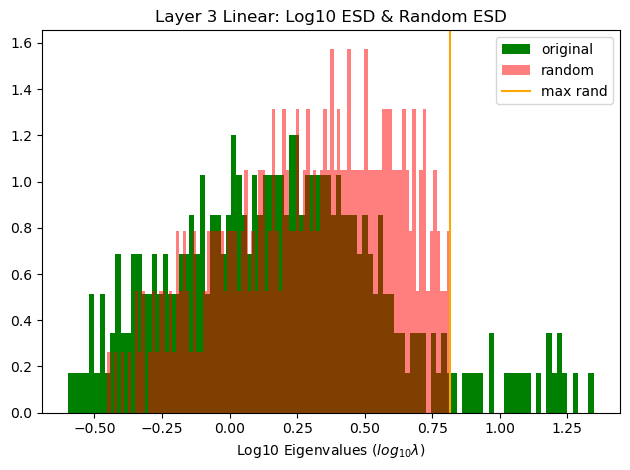

0    2.460328
Name: alpha, dtype: float64


<Figure size 640x480 with 0 Axes>

In [3]:
m = MLP3(widths=(300, 100), H=28, W=28, C=1)
t = Trainer(m)

DS = "MNIST"
OPT = "SGD"
layer = "all"
FC1 = 3
FC2 = 5
model_name = f"SETOL/{DS}/{layer}/BS_2"
for run in range(5):
  E = last_epoch(run, model_name)
  t.load(run, E, model_name)
  watcher = WeightWatcher(m)
  figdir = f"figs/correlation_traps/BS_2_FC1_{run}"
  Path(figdir).mkdir(parents=True, exist_ok=True)
  details = watcher.analyze(layers = [FC1], randomize=True, plot=["log_rand_esd"], savefig=figdir)
  print(details.alpha)

-----
### Now, when batch size is 2, the <font color='orange'>orange</font> line is back where it normally is.

This is tells us that the distribution of the weights is "normal" enough that it doesn't produce an eigenvalue outside of the MP distribution's support set when the elements are permuted. Recall from the first experiment in `WW_MLP3_Analysis_Model_Quality.ipynb`, that when accuracy was affected by batch size changing from $2$ to $1$, $\alpha_\mbox{FC1}$ dropped below $2.0$ in this layer, FC1. In the second layer, FC2, $\alpha_\mbox{FC2}$ still remained above 2.0, but its error bar drastically increased. 

This suggests that part of the reason why $\alpha_\mbox{FC1}$ was below $2$ may be because there was a single large eigenvalue corresponding to the non-zero mean of the weights, and that large eigenvalue distorted the power law calculation.

### Next, let's see if there are any Correlation Traps in FC2...
Recall that $\alpha_\mbox{FC2} > 2.0$. 

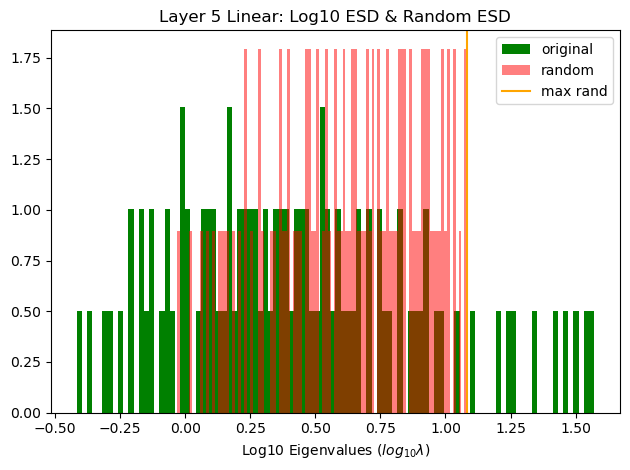

0    2.123228
Name: alpha, dtype: float64


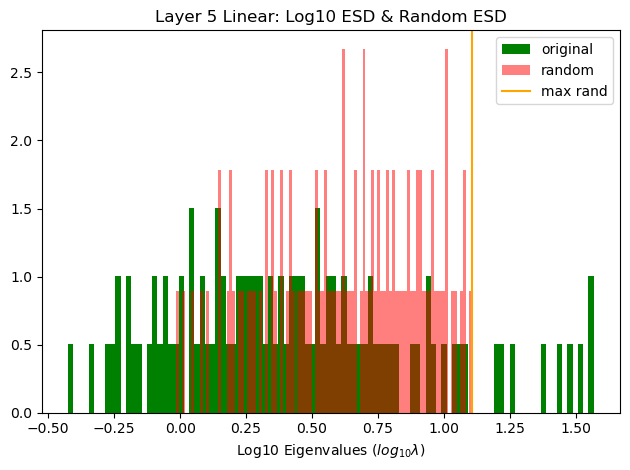

0    2.072299
Name: alpha, dtype: float64


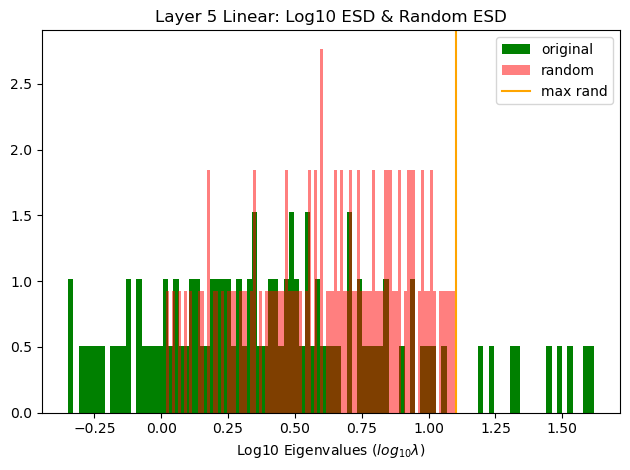

0    2.153264
Name: alpha, dtype: float64


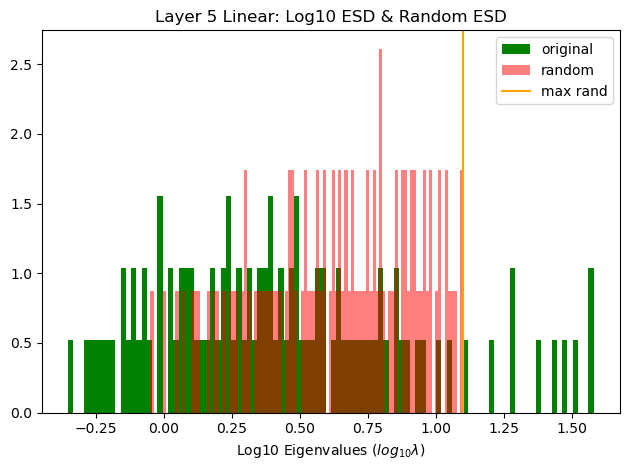

0    2.049268
Name: alpha, dtype: float64


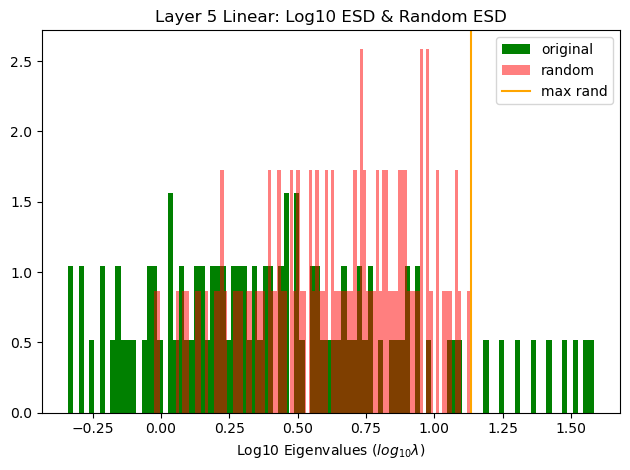

0    2.20932
Name: alpha, dtype: float64


<Figure size 640x480 with 0 Axes>

In [4]:
m = MLP3(widths=(300, 100), H=28, W=28, C=1)
t = Trainer(m)

DS = "MNIST"
layer = "all"
FC1 = 3
FC2 = 5
model_name = f"SETOL/{DS}/{layer}/BS_1"
for run in range(5):
  E = last_epoch(run, model_name)
  t.load(run, E, model_name)
  watcher = WeightWatcher(m)
  figdir = f"figs/correlation_traps/BS_1_FC2_{run}"
  Path(figdir).mkdir(parents=True, exist_ok=True)
  details = watcher.analyze(layers = [FC2], randomize=True, plot=["log_rand_esd"], savefig=figdir)
  print(details.alpha)

### Just as expected, we see that FC2 doesn't have a correlation trap, even with batch size of $1$. We expect this (usually) whenever $\alpha_\mbox{FC2}$ is above $2.0$.

We can also try varying the Learning Rate (LR) instead of batch size. In a second set of experiments, the batch size was set to $32$, and the learning rate was varied by powers of two in $1 \ldots 32$. Having an LR of 32 is roughly equivalent to having a batch size of $1$. Here, we can see that $\alpha_\mbox{FC1}$ is consistently about $1.9$, and there are Correlation Traps.

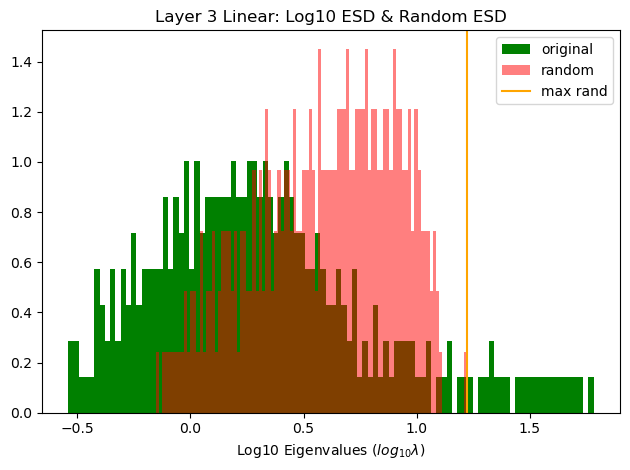

0    1.953559
Name: alpha, dtype: float64


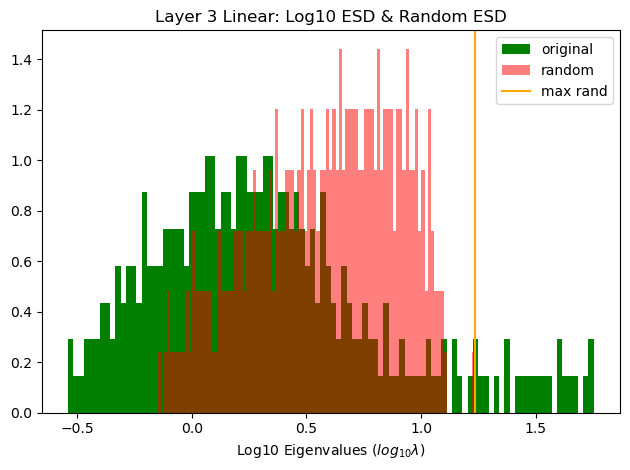

0    1.957183
Name: alpha, dtype: float64


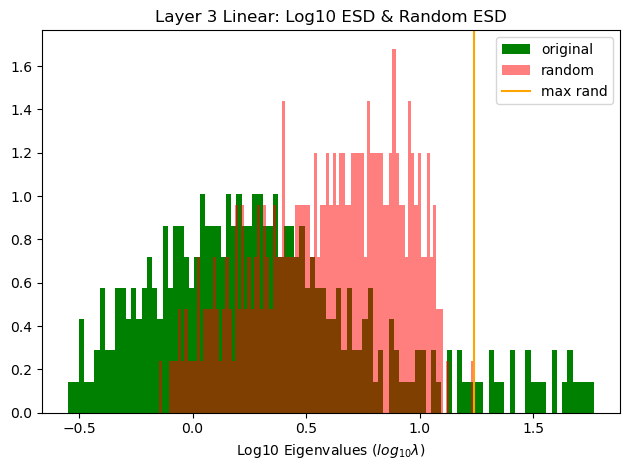

0    1.943976
Name: alpha, dtype: float64


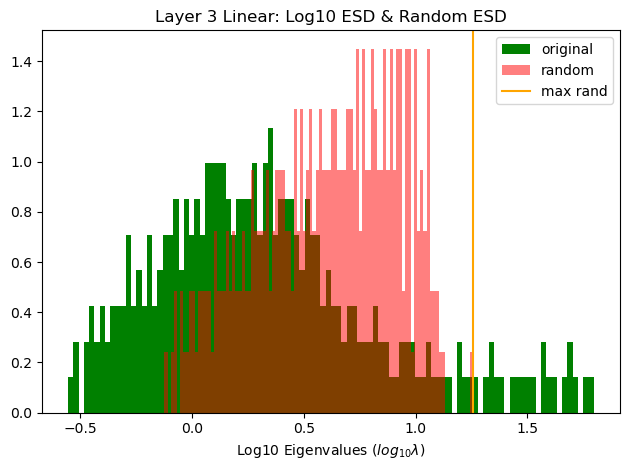

0    1.94657
Name: alpha, dtype: float64


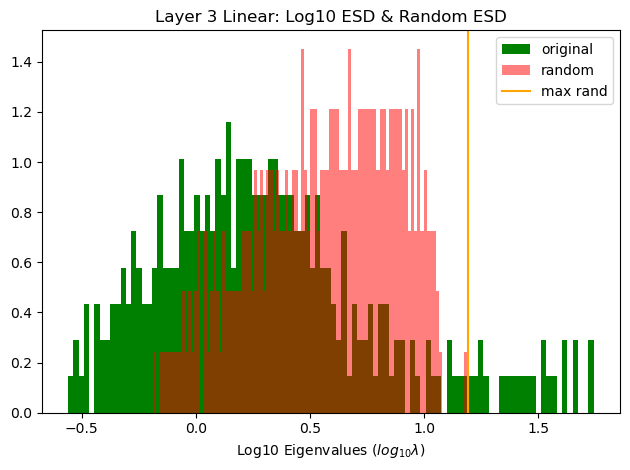

0    1.978357
Name: alpha, dtype: float64


<Figure size 640x480 with 0 Axes>

In [5]:
m = MLP3(widths=(300, 100), H=28, W=28, C=1)
t = Trainer(m)

DS = "MNIST"
layer = "all"
FC1 = 3
FC2 = 5
model_name = f"SETOL/{DS}/{layer}/LR_32"
for run in range(5):
  E = last_epoch(run, model_name)
  t.load(run, E, model_name)
  watcher = WeightWatcher(m)
  figdir = f"figs/correlation_traps/LR_32_FC1_{run}"
  Path(figdir).mkdir(parents=True, exist_ok=True)
  details = watcher.analyze(layers = [FC1], randomize=True, plot=["log_rand_esd"], savefig=figdir)
  print(details.alpha)

### Once again, the $\alpha$ values are just under $2.0$ and again there are (smaller) Correlation Traps.

Finally, let's see what the FC2 layer is like in this case:

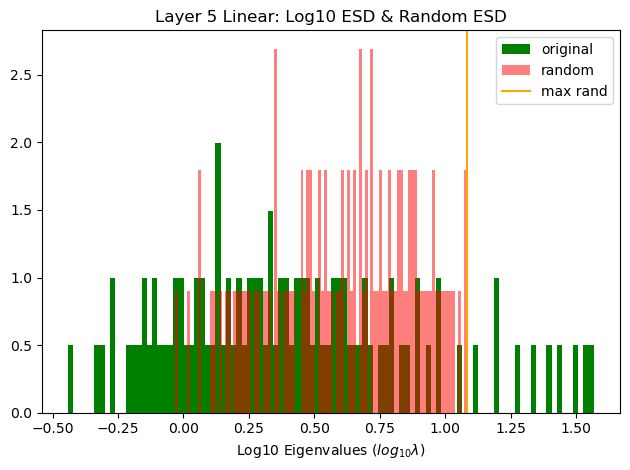

0    2.100091
Name: alpha, dtype: float64


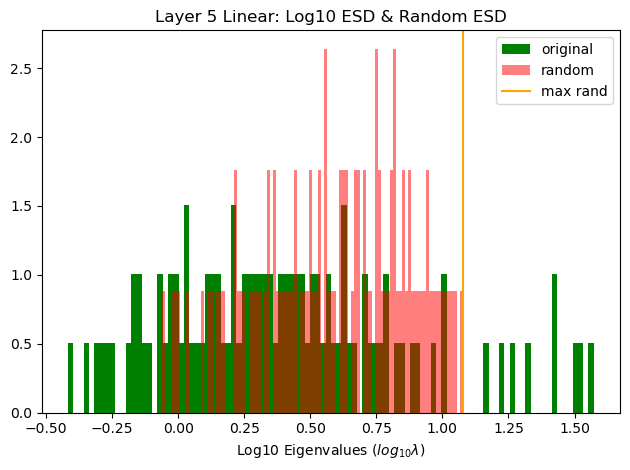

0    2.092943
Name: alpha, dtype: float64


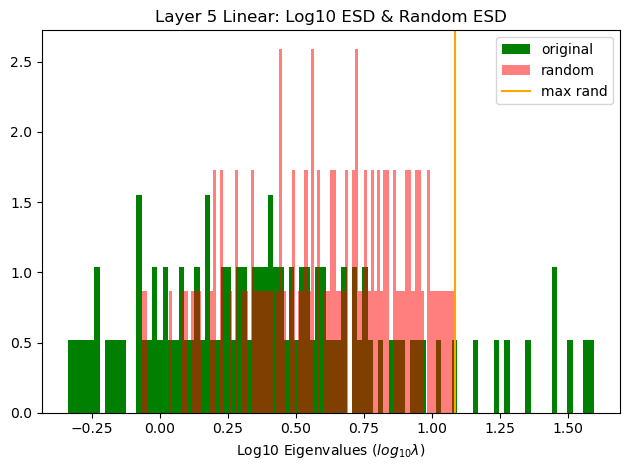

0    2.110221
Name: alpha, dtype: float64


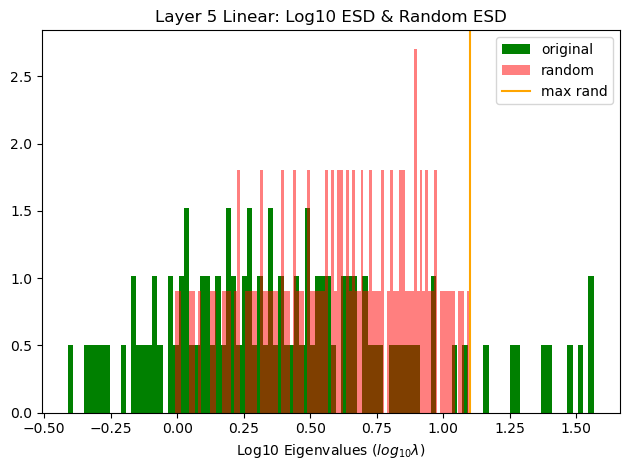

0    2.078853
Name: alpha, dtype: float64


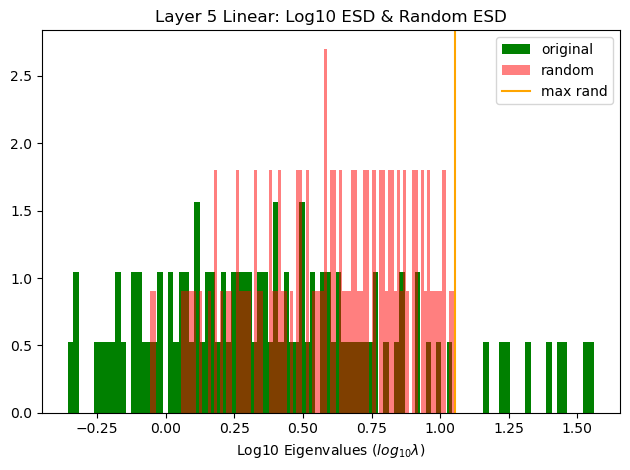

0    2.122223
Name: alpha, dtype: float64


<Figure size 640x480 with 0 Axes>

In [6]:
m = MLP3(widths=(300, 100), H=28, W=28, C=1)
t = Trainer(m)

DS = "MNIST"
layer = "all"
FC1 = 3
FC2 = 5
model_name = f"SETOL/{DS}/{layer}/LR_32"
for run in range(5):
  E = last_epoch(run, model_name)
  t.load(run, E, model_name)
  watcher = WeightWatcher(m)
  figdir = f"figs/correlation_traps/LR_32_FC2_{run}"
  Path(figdir).mkdir(parents=True, exist_ok=True)
  details = watcher.analyze(layers = [FC2], randomize=True, plot=["log_rand_esd"], savefig=figdir)
  print(details.alpha)

### And yet again, the $\alpha$ values are just *over* $2.0$ and again there are no Correlation Traps.